In this notebook I want advance some of the work which we've implemented in previous notebooks. 

First of all, our best model so far got a test MAE of 0.113 for nowcasting from notebook `006`. I haven't been able to beat this accuracy since then. I also was only able to achieve an accuracy of 0.126 when predicting sequences in `010`. Therefore I want to take the structure of the networkks from `006` and repeat `010`. 

Also in `007` I made a climatolgy baseline. I ended up training this twice, with the second time coming out as a much worse score (first time ~0.2 and second time ~0.3) so I want to rerun this 

Finally I want to train a more intelligent baseline which doesn't use any convolutional layers. The question being how much information is there in the spatial aspects of the data. For the NWP I already know there is very little spatial information.


In [2]:
import src
import imp
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

In [3]:
import imp
imp.reload(src.features.preprocessing)

<module 'src.features.preprocessing' from '/home/davidjamesfulton93/repos/predict_pv_yield/src/features/preprocessing.py'>

In [4]:
pv_metadata_df = src.data.load_pv.load_pv_metadata("~/repos/predict_pv_yield/data/"+src.data.load_pv.PV_METADATA_FILEPATH)

In [5]:
pv_metadata_df.head()

,system_name,system_size_watts,postcode,number_of_panels,panel_power_watts,panel_brand,num_inverters,inverter_power_watts,inverter_brand,orientation,...,install_date,latitude,longitude,status_interval_minutes,number_of_panels_secondary,panel_power_watts_secondary,orientation_secondary,array_tilt_degrees_secondary,x,y
system_id,,,,,,,,,,,,,,,,,,,,,
690,3.8kw of Power @ No3,3800,NaN,20,190,Phono Solar,1,4000,SMA Sunny Boy 4000,S,...,2010-12-01 00:00:00,52.087171,-0.263414,10,0,0,NaN,NaN,519080.191006,244623.301288
709,Grove Cottages,2460,RG4,12,205,Romag PowerGlaz SMT6(54)P,1,3000,SMA Sunny Boy 3000TL,SE,...,2010-09-28 00:00:00,51.485329,-0.967526,5,0,0,NaN,NaN,471786.316866,176769.072244
777,Underfell1,3420,NaN,18,190,Schuco MPE 190 MS 05,1,4000,SMA Sunny Boy 4000TL,SW,...,2010-10-29 00:00:00,54.197863,-2.938757,10,0,0,NaN,NaN,338853.840270,478417.935178
794,Roofline,3700,GU34,20,185,Sharp,1,4000,SMA,SE,...,2011-01-05 00:00:00,51.112485,-1.032715,5,0,0,NaN,NaN,467806.490433,135244.187025
973,number38,4000,WA11,16,250,Sungrid/SG250M6,1,3800,Sunny Boy 3800,SW,...,2011-01-13 00:00:00,53.467927,-2.675806,5,0,0,NaN,NaN,355234.617987,397009.685712


In [6]:
pv_power_df = src.data.load_pv.load_pv_power(filepath="~/repos/predict_pv_yield/data/"+src.data.load_pv.PV_DATA_FILEPATH, start='2018-01-01', end='2019-12-31')

In [7]:
pv_power_df = pv_power_df.dropna(axis=0, how='all')

In [8]:
pv_power_df.head()

,690,709,794,973,1364,1556,1627,1646,1647,1872,...,68000,68212,68218,68219,68303,68324,68404,68443,68800,68846
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 03:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:35:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:50:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Drop systems (in-place) without PV data and metadata
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [10]:
# make clearsky GHI object
latitude, longitude = pv_metadata_df.loc[pv_power_df.columns, ['latitude', 'longitude']].values.T
ghiscalar = src.features.transformers.ClearskyScalar(latitude, longitude)

# filter data to daylight hours (in-place)
ghiscalar.filter_to_daylight(pv_power_df, min_ghi=5, inplace=True)

In [11]:
# drop rows systems with no daylight
pv_power_df = pv_power_df.dropna(axis=0, how='all')
src.features.preprocessing.filter_to_power_metadata_match(pv_metadata_df, pv_power_df)

In [12]:
# scale by max power output
rminmax = src.features.transformers.RobustMinMaxScaler(saturation_fraction=0.01)
pv_prop_max_df = rminmax.fit_transform(pv_power_df)

In [13]:
y_train_time, y_test_time = src.features.preprocessing.train_test_split_day(pv_prop_max_df, 0.2, shuffle=True, seed=4384321)

from sklearn.model_selection import train_test_split
train_columns, test_columns= train_test_split(pv_prop_max_df.columns, test_size=0.2, random_state=87695)

# different systems and different times
y_train = y_train_time.reindex(columns=train_columns, copy=False)
y_test_systemtime = y_test_time.reindex(columns=test_columns, copy=False)

In [14]:
src.data.sat_loader.AVAILABLE_CHANNELS

,description
channel_name,
VIS006,"λ_central=0.635µm, λ_min=0.56µm, λ_max=0.71µm,..."
VIS008,"λ_central=0.81µm, λ_min=0.74µm, λ_max=0.88µm, ..."
IR_016,"λ_central=1.64µm, λ_min=1.50µm, λ_max=1.78µm, ..."
IR_039,"λ_central=3.90µm, λ_min=3.48µm, λ_max=4.36µm, ..."
WV_062,"λ_central=6.25µm, λ_min=5.35µm, λ_max=7.15µm, ..."
WV_073,"λ_central=7.35µm, λ_min=6.85µm, λ_max=7.85µm, ..."
IR_087,"λ_central=8.70µm, λ_min=8.30µm, λ_max=9.1µm, |..."
IR_097,"λ_central=9.66µm, λ_min=9.38µm, λ_max=9.94µm, ..."
IR_108,"λ_central=10.80µm, λ_min=9.80µm, λ_max=11.80µm..."


In [15]:
sat_channels = src.data.sat_loader.DEFAULT_CHANNELS
sat_channels

['VIS006',
 'VIS008',
 'IR_016',
 'IR_039',
 'WV_062',
 'WV_073',
 'IR_087',
 'IR_097',
 'IR_108',
 'IR_120',
 'IR_134',
 'HRV']

I'm going to use the same channels as I did in `006`.

In `006` I only used 22km patches which were motivated by what size patch of sky (at average height of clouds) is visible to any point on ground. This was for nowcasting though. 

Later I chose 144km as this represented the approximate size scale of how much clouds would move in an hour but got a worse MAE for nowcasting in `007` with this size. I don't know if the difference in score between `006` and `007` was because of this, but it potentially might have reduced performance just by making the network harder to train. I'm not sure if `007` performed worse because of this but I think it is worth considerig

I'm not sure what the right answer is going to be here, so I will set up the loader to load 144km again and I will try a few different values from this.

In `006` I also didn't load any sequences, just the most recent satellite image. I don't want the complexity of making recurrent networks so I'll stick to this.

In [16]:
satloader = src.data.sat_loader.SatelliteLoader(height=144_000, width=144_000, channels=sat_channels)

In [17]:
src.data.nwp_loader.AVAILABLE_CHANNELS

,description
channel_name,
t,1.5m air temperature at surface
r,1.5m Relative humidity
dpt,1.5m dew point temperature
vis,1.5m visibility
si10,10m wind speed
wdir10,10m wind direction
prmsl,Mean sea level pressure
unknown_1,Uncertain. This is likely '1.5m fog probability'
unknown_2,Uncertain. This is likely 'snow fraction'


In `006` I didn't use the last two variables below,  `'si10'` and `'wdir10'` but I think these could be important for forecasting since it should tell the network which way the cloud decks should be moving so I'll keep them.

For predicting sequences previously I used 3 times for the forecast : the integer hour before the start of the sequence, the hour in the middle of the sequence and the hour after. 
So for example if the sequence was every five minutes starting at 12:15 and ending at 13:15 then I would feed the network the NWp for 12:00, 13:00 and 14:00. 

There is a problem here which is that I am uncertain in the NWP what the forecast on the hour means. i.e. does the data at time HH:00 represent the average of variables between HH:00-{HH+1}:00 or between {HH-1}:30-{HH+1}:30? I have been assuming it is the former but I don't have any confimation of this.

For this reason I am uncertain about how it would be best to use multiple time frames of NWP forecast. So instead I am only going to use one.

In these experiments, if the sequence runs from HH:MM - {HH+1}:MM then I'd ideally like `(NWP(HH)*(60-MM) + NWP(HH+1)*MM)/60` which roughly estimate the average NWP values over the time of the sequence assuming the forecasts are averaged between integer hours. If it is half hours then I will have estimated forecasts centred 30mins before what I intended. 

In [18]:
nwp_channels = ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf', 'si10', 'wdir10']

In [19]:
nwploader = src.data.nwp_loader.NWPLoader(height=144_000, width=144_000, time_slice=[0,1], channels=nwp_channels)

In [20]:
y_meta_train = pv_metadata_df.reindex(y_train.columns, copy=False)
y_meta_test_systemtime = pv_metadata_df.reindex(y_test_systemtime.columns, copy=False)

In the earliest experiments using only satellite `HRV` we got much better MAE than we did after we normalised y differently and added in more channels. Partly this may be becaused we stopped using the pvlib calculated irradiance. Unfortunately calculating the all 3 clearsky indices is pretty slow, and the batch loader needs to be modified to accommodate this kind of data, so for now I want to use just the clearsky GHI which can be calculated quickly. At a later date I should come back to this since I can see how DHI could also be an informative feature.

In [22]:
clearsky_df = ghiscalar.haurwitz_ghi(pv_power_df.index)
clearsky_df = pd.DataFrame(clearsky_df, index=pv_power_df.index, columns=pv_power_df.columns)
clearsky_df = clearsky_df / clearsky_df.max().max()
clearsky_df.index = clearsky_df.index.values

In [31]:
clearsky_train = clearsky_df.reindex(index=y_train.index.values, columns=y_train.columns, copy=False)
clearsky_test = clearsky_df.reindex(index=y_test_systemtime.index.values, columns=y_test_systemtime.columns, copy=False)

In [ ]:
def xr_unique(ds):
    index = np.sort(np.unique(ds.time, return_index=True)[1])
    return ds.isel(time=index)

satloader.dataset = xr_unique(satloader.dataset)

In [108]:
gc.collect()

3073

In [109]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            51G         24G         25G         21M        848M         25G
Swap:            0B          0B          0B


In [112]:
# Do some nowcasting with sat only
batch_generator = src.data.batch_loader.cross_processor_batch(
            y_train, 
            y_meta_train, 
            y_index_sequence=[0,1,2,3,4,5,6,7,8,9,10,11,12],
            max_missing_sequence_vals=4,
            clearsky=clearsky_train,
            sat_loader=satloader,
            nwp_loader=nwploader,
            include_tod=True,
            include_toy=True,
            include_latlon=True,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=256, 
            batches_per_superbatch=100, 
            n_superbatches=None, 
            n_epochs=1, 
            gpu=1,
            samples_per_datetime=100,
            parallel_loading_cores=2)

In [113]:
batch = next(batch_generator)

In [119]:
test_batch_generator = src.data.batch_loader.cross_processor_batch(
            y_test_systemtime, 
            y_meta_test_systemtime, 
            y_index_sequence=[0,1,2,3,4,5,6,7,8,9,10,11,12],
            max_missing_sequence_vals=0,
            clearsky=clearsky_test,
            sat_loader=satloader,
            nwp_loader=nwploader,
            include_tod=True,
            include_toy=True,
            include_latlon=True,
            lead_time=pd.Timedelta('0 days 00:00:00'),
            batch_size=1000, 
            batches_per_superbatch=1, 
            n_superbatches=1, 
            n_epochs=None, 
            gpu=1,
            samples_per_datetime=1,
            parallel_loading_cores=1)

%time test_batch = next(test_batch_generator)

CPU times: user 35min 23s, sys: 5min 58s, total: 41min 21s
Wall time: 28min 18s


In [120]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import torch

In [181]:
def conv_output_size(H_in, kernel_size, padding, dilation, stride):
    return int((H_in+2*padding - dilation * (kernel_size-1)-1)/stride + 1)

# modification of version from notebook 007. Added selecting subpatch from sat/NWP
class Net(nn.Module):
    def __init__(self, net_sat_channels, 
                 net_nwp_channels, 
                 conv_hidden_units,
                 image_side_length = 11,
                 include_clearsky=True,
                 include_tod=True, 
                 include_toy=False, 
                 include_latlon=False,
                 conv_kernel_size=5, 
                 fc_hidden_units=[1], 
                 conv_batchnorm=False,
                 fc_batchnorm=False,
                 activation=nn.LeakyReLU(),
                 output_activation=F.relu,
                 dropout_frac=0.):
        
        self.config = dict(
                 net_sat_channels=net_sat_channels, 
                 net_nwp_channels=net_nwp_channels, 
                 conv_hidden_units=conv_hidden_units,
                 image_side_length=image_side_length,
                 include_clearsky=include_clearsky,
                 include_tod=include_tod,
                 include_toy=include_toy,
                 include_latlon=include_latlon,
                 conv_kernel_size=conv_kernel_size, 
                 fc_hidden_units=fc_hidden_units, 
                 conv_batchnorm=conv_batchnorm,
                 fc_batchnorm=fc_batchnorm,
                 activation=str(activation),
                 output_activation=str(output_activation),
                 dropout_frac=dropout_frac
        )
        
        super(Net, self).__init__()
        #nn.Dropout2d ()
        # save channel indexes
        self.sat_indexes = [i for i, channel in enumerate(sat_channels) if channel in net_sat_channels]
        self.nwp_indexes = [i for i, channel in enumerate(nwp_channels) if channel in net_nwp_channels]
        
        self.conv_hidden_units = conv_hidden_units
        self.conv_batchnorm = conv_batchnorm
        
        self.fc_hidden_units = fc_hidden_units
        self.fc_batchnorm = fc_batchnorm
        
        self.dropout_frac = dropout_frac
        self.activation = activation
        self.output_activation = output_activation
        
        self.include_clearsky = include_clearsky
        self.include_tod = include_tod
        self.include_toy = include_toy
        self.include_latlon = include_latlon

        # set up convolutional layers
        if len(conv_hidden_units)>0:
            self.convs = [nn.Conv2d(in_channels=len(net_sat_channels)+len(net_nwp_channels), 
                                    out_channels=self.conv_hidden_units[0],
                                    kernel_size=conv_kernel_size)]
            self.convs.extend([nn.Conv2d(in_channels=self.conv_hidden_units[i-1], 
                                    out_channels=self.conv_hidden_units[i],
                                    kernel_size=conv_kernel_size)
                         for i in range(1,len(self.conv_hidden_units))])
        
        #  set up convolutional batch-norms
        if conv_batchnorm:
            self.conv_norm = [nn.BatchNorm2d(c) for c in conv_hidden_units]
        
        # keep track of convolutional image size
        self.image_sizes = [image_side_length]
        for i in range(len(conv_hidden_units)):
            self.image_sizes.append(conv_output_size(self.image_sizes[-1], conv_kernel_size, 0, 1, 1))
        
        # set up fully connected layers
        if len(fc_hidden_units)>0:
            # calculate the zeroth number of nodes
            if (len(self.sat_indexes) + len(self.nwp_indexes))>0:
                h0 = self.image_sizes[-1]**2*self.conv_hidden_units[-1]
            else:
                h0 = 0
            h0 += include_tod + include_toy + 2*include_latlon + include_clearsky
            self.fc = [nn.Linear(h0, fc_hidden_units[0])] 
            self.fc.extend([nn.Linear(fc_hidden_units[i-1], fc_hidden_units[i]) for i in range(1,len(fc_hidden_units))])
            
        # set up convolutional batch norms
        if fc_batchnorm:
            self.fc_norm = [nn.BatchNorm1d(h) for h in fc_hidden_units]
        
        
        if dropout_frac>0:
            self.dropout = nn.Dropout(p=dropout_frac)
            
        # compile layers
        l = []
        if len(conv_hidden_units)>0: l+=self.convs
        if conv_batchnorm:           l+= self.conv_norm
        if len(fc_hidden_units)>0:   l+=self.fc
        if fc_batchnorm:             l+=self.fc_norm
        
        self.module_list = nn.ModuleList(l)


    def forward(self, batch):
        
        if (len(self.sat_indexes) + len(self.nwp_indexes))>0:
            if len(self.sat_indexes)>0 and len(self.nwp_indexes)>0:
                x = torch.cat((batch['satellite'][:,self.sat_indexes], batch['nwp'][:, self.nwp_indexes]), dim=1)
            elif len(self.sat_indexes)>0:
                x = batch['satellite'][:,self.sat_indexes]
            elif len(self.nwp_indexes)>0:
                x = batch['nwp'][:, self.nwp_indexes]
            
            # cut image to size
            n1 =  (x.shape[2] - self.image_sizes[0])//2
            n2 = x.shape[2] - n1
            x = x[:, :, n1:n2, n1:n2]
            
            for i in range(len(self.convs)):
                x = self.convs[i](x)
                if self.conv_batchnorm:
                    x = self.conv_norm[i](x)
                if self.dropout_frac>0:
                    x = self.dropout(x)
                x = self.activation(x)

            data = [x.view(x.shape[0], -1)]

        else:
            data = []
            
        if self.include_clearsky: data.append(batch['clearsky'].view(-1,1))
        if self.include_tod: data.append(batch['day_fraction'].view(-1,1))
        if self.include_toy: data.append(batch['year_fraction'].view(-1,1))
        if self.include_latlon: data.append(batch['latlon'].view(-1,2))

        if len(data)>1:
            x = torch.cat(data, dim=1)
        else:
            x = data[0]

        for i in range(len(self.fc)):
            x = self.fc[i](x)
            if i!=len(self.fc)-1:
                if self.conv_batchnorm:
                    x = self.fc_norm[i](x)
                if self.dropout_frac>0:
                    x = self.dropout(x)
                x = self.activation(x)
                
        x = self.output_activation(x)
        
        return x

In [122]:
def torch_nan_mse(ypred, y):
    mask = ~torch.isnan(y)
    dy2 = (y[mask]-ypred[mask])**2
    return dy2.mean()

def torch_nan_mae(ypred, y):
    mask = ~torch.isnan(y)
    dy = torch.abs(y[mask]-ypred[mask])
    return dy.mean()

In [123]:
# Up to 4/13 y-values in each target sequence are NaN,
# loss functions must accept this
MSE_LOSS_FUNC = torch_nan_mse
MAE_LOSS_FUNC = torch_nan_mae

In [124]:
import json

MODEL_DUMP_ROOT = os.path.expanduser('~/model_dump/013')
os.makedirs(MODEL_DUMP_ROOT, exist_ok=True)

class net_container:
    def __init__(self, net, optimizer, loss_func=MSE_LOSS_FUNC, run_name=None):
        self.net = net
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.run_name = run_name
        
        self.running_train_loss = 0
        self.running_train_mse = 0
        self.running_train_mae = 0
        
        self.train_losses = []
        self.train_mse_losses = []
        self.train_mae_losses = []
        
        self.test_losses = []
        self.test_mse_losses = []
        self.test_mae_losses = []
        self.batch = []
        self.time_elapsed = []
        
    
    def train_step(self, batch, batch_number):
        
        # zero the parameter gradients
        self.optimizer.zero_grad()

        # forward + backward + optimize
        self.net.train()
        
        outputs = self.net(batch)
        train_loss = self.loss_func(outputs, batch['y'])
        self.running_train_loss += train_loss.item()
        
        train_loss.backward()
        self.optimizer.step()
        
        # MAE
        train_mae = MAE_LOSS_FUNC(outputs, batch['y'])
        self.running_train_mae += train_mae.item()
        
        # MSE
        train_mse = MSE_LOSS_FUNC(outputs, batch['y'])
        self.running_train_mse += train_mse.item()

        # print statistics
        if batch_number == 0 or batch_number % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches

            # Train loss
            if batch_number == 0:
                mean_train_loss = self.running_train_loss
                mean_train_mse = self.running_train_mse
                mean_train_mae = self.running_train_mae
                self.t0 = time.time()
            else:
                mean_train_loss = self.running_train_loss / STATS_PERIOD
                mean_train_mse = self.running_train_mse / STATS_PERIOD
                mean_train_mae = self.running_train_mae / STATS_PERIOD

            self.train_losses.append(mean_train_loss)
            self.train_mse_losses.append(mean_train_mse)
            self.train_mae_losses.append(mean_train_mae)
            
            self.running_train_loss = 0.
            self.running_train_mse = 0.
            self.running_train_mae = 0.

            # Test loss
            self.net.eval()
            test_outputs = self.net(test_batch)
            
            test_loss = self.loss_func(test_outputs, test_batch['y']).item()
            self.test_losses.append(test_loss)
            test_mae = MAE_LOSS_FUNC(test_outputs, test_batch['y']).item()
            self.test_mae_losses.append(test_mae)
            test_mse = MSE_LOSS_FUNC(test_outputs, test_batch['y']).item()
            self.test_mse_losses.append(test_mse)
            
            self.batch.append(batch_number)
            self.time_elapsed.append(time.time() - self.t0)
            
            if self.run_name:
                thisdir = os.path.join(MODEL_DUMP_ROOT, self.run_name)
                if batch_number==0:
                    
                    os.system(f"rm -rf {thisdir}")
                    os.makedirs(os.path.join(thisdir, "figures"))
                    
                    with open(os.path.join(thisdir, 'config.json'), 'w') as f:
                        json.dump(self.net.config, f, indent=4)
                              
                df = pd.DataFrame({
                    'time_elapsed':self.time_elapsed,
                    'batch':self.batch,
                    'train_loss':self.train_losses,
                    'train_mse':self.train_mse_losses,
                    'train_mae':self.train_mae_losses,
                    'test_loss':self.test_losses,
                    'test_mse':self.test_mse_losses,
                    'test_mae':self.test_mae_losses,
                }).to_csv(os.path.join(thisdir, 'training_stats.csv'))
                
                if test_loss == min(self.test_losses):
                    torch.save(self.net, os.path.join(thisdir, 'best_model.pkl'))
                    

In [182]:
# This is esentially the same structure as the best net from 006 except the number of outputs
# Also using 24km instead of 22km for a subtle positioning reason
hybrid_net_006_recreation = Net(
           ['VIS006','VIS008','IR_016','IR_039','WV_062','WV_073','IR_087','IR_097','IR_108','IR_120','IR_134','HRV'],
           ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf'], 
           conv_hidden_units=[50, 50],
           image_side_length=12,
           conv_kernel_size=5,
           fc_hidden_units=[100, 100, 20, 13],
           include_clearsky=False,
           include_tod=True, 
           include_toy=False, 
           include_latlon=False,
           conv_batchnorm=True,
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=F.relu,
           dropout_frac=0.
).cuda().half()

# try adding clearsky
hybrid_net_006_recreation2 = Net(
           ['VIS006','VIS008','IR_016','IR_039','WV_062','WV_073','IR_087','IR_097','IR_108','IR_120','IR_134','HRV'],
           ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf'], 
           conv_hidden_units=[50, 50],
           image_side_length=12,
           conv_kernel_size=5,
           fc_hidden_units=[100, 100, 20, 13],
           include_clearsky=True,
           include_tod=True, 
           include_toy=False, 
           include_latlon=False,
           conv_batchnorm=True,
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=F.relu,
           dropout_frac=0.
).cuda().half()


# try using bigger image
hybrid_net_006_widerview = Net(
           ['VIS006','VIS008','IR_016','IR_039','WV_062','WV_073','IR_087','IR_097','IR_108','IR_120','IR_134','HRV'],
           ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf'], 
           conv_hidden_units=[50, 50],
           image_side_length=30,
           conv_kernel_size=5,
           fc_hidden_units=[100, 100, 20, 13],
           include_clearsky=True,
           include_tod=True, 
           include_toy=False, 
           include_latlon=False,
           conv_batchnorm=True,
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=F.relu,
           dropout_frac=0.
).cuda().half()


# try using even bigger image and adjust kernel size appropriately
hybrid_net_006_widestview = Net(
           ['VIS006','VIS008','IR_016','IR_039','WV_062','WV_073','IR_087','IR_097','IR_108','IR_120','IR_134','HRV'],
           ['t', 'r', 'vis', 'prmsl', 'prate', 'lcc', 'mcc', 'hcc', 'dswrf'], 
           conv_hidden_units=[50, 50],
           image_side_length=72,
           conv_kernel_size=11,
           fc_hidden_units=[100, 100, 20, 13],
           include_clearsky=True,
           include_tod=True, 
           include_toy=False, 
           include_latlon=False,
           conv_batchnorm=True,
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=F.relu,
           dropout_frac=0.
).cuda().half()



climatology_net =  Net([], [], 
           include_clearsky=False,
           include_tod=True,
           include_toy=True, 
           include_latlon=True,
           conv_hidden_units=[],
           fc_hidden_units=[20,20,6,13],
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=F.relu,
           dropout_frac=0.
).cuda().half()


clearsky_net =  Net([], [], 
           include_clearsky=True,
           include_tod=True,
           include_toy=True, 
           include_latlon=True,
           conv_hidden_units=[],
           fc_hidden_units=[20,20,6,13],
           fc_batchnorm=True,
           activation=nn.LeakyReLU(),
           output_activation=F.relu,
           dropout_frac=0.
).cuda().half()


In [183]:
def sgd_training_container(net, name):
    return net_container(
        net,
        optimizer=optim.SGD(net.parameters(), lr=0.01, momentum=0.8), 
        loss_func=MSE_LOSS_FUNC,
        run_name=name,
    )

In [189]:
containers = [
    sgd_training_container(net, name) for net, name in 
              [(hybrid_net_006_recreation, 'recreation'),
               (hybrid_net_006_recreation2,'recreation_w_clearsky'),
               (hybrid_net_006_widerview,'recreation_with_widerview'),
               (hybrid_net_006_widestview,'recreation_with_widestview'),
               (climatology_net,'climatology'),
               (clearsky_net,'clearsky_climatology'),
              ]   
]


In [186]:
STATS_PERIOD = 100

In [146]:
def centre_nwp(batch):
    day_frac = batch['day_fraction']
    if len(day_frac.shape)==2: day_frac=day_frac[:,0]
    frac_hour = day_frac*24 - torch.floor(day_frac*24)
    mymul = lambda x, y : torch.mul(x.T, y).T
    return mymul(batch['nwp'][...,0], 1-frac_hour) +  mymul(batch['nwp'][...,1], frac_hour)
    

def modify_batch(batch, inplace=False):
    if inplace:
        for k,v in batch.items():
            if k=='y':
                continue
            elif k=='nwp':
                batch[k] = centre_nwp(batch)
            else:
                batch[k] = v[...,0]
        return batch
    else:
        mod_batch = {}
        for k,v in batch.items():
            if k=='y':
                mod_batch[k] = v
            elif k=='nwp':
                mod_batch[k] = centre_nwp(batch)
            else:
                mod_batch[k] = v[...,0]
        return mod_batch

In [130]:
test_batch = modify_batch(test_batch, inplace=True)

In [190]:
batch_generator.batch_index=0

In [ ]:
shuffles_per_superbatch = 4
current_shuffles = 1

for i_batch, batch in enumerate(batch_generator):
    
    batch = modify_batch(batch)
    
    for container in containers:
        print(f'batch:{i_batch:03} | {container.run_name:30s}\r', end="")
        container.train_step(batch, i_batch)
        
    # if we have got to end of superbatch reshuffle
    if batch_generator.batch_index==(batch_generator.batches_per_superbatch-1):
        # but only if we haven't already shuffled so mnay times
        if current_shuffles < shuffles_per_superbatch:
            batch_generator.shuffle_cpu_superbatch()
            if batch_generator.gpu==2: batch_generator.transfer_superbatch_to_gpu()
            batch_generator.batch_index = 0
            current_shuffles+=1
        # if we have shiuffled our limit of times then update shuffle tally
        elif current_shuffles >= shuffles_per_superbatch:
            print(f'batch:{i_batch} - reshuffled this super-batch too many times. Loading new.\r', end="")
            current_shuffles = 1


print('\nFinished Training')

/home/davidjamesfulton93/repos/predict_pv_yield/src/data/batch_loader.py:541: UserWarning: 
                                exceeded 20. This may imply a data issue.

                                
  """.format(repeats))
/home/davidjamesfulton93/repos/predict_pv_yield/src/data/batch_loader.py:541: UserWarning: 
                                exceeded 40. This may imply a data issue.

                                
  """.format(repeats))


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [197]:
import glob
model_dumps = [x.split('/')[-1] for x in glob.glob(os.path.expanduser('~/model_dump/013/*')) if not x.endswith('ipynb')]
#model_dumps = [x for x in model_dumps if '1' not in x]

In [198]:
dfs = [pd.read_csv(f'~/model_dump/013/{model}/training_stats.csv', ).set_index('batch')\
       for model in model_dumps]

Note I stopped the medium sized network early

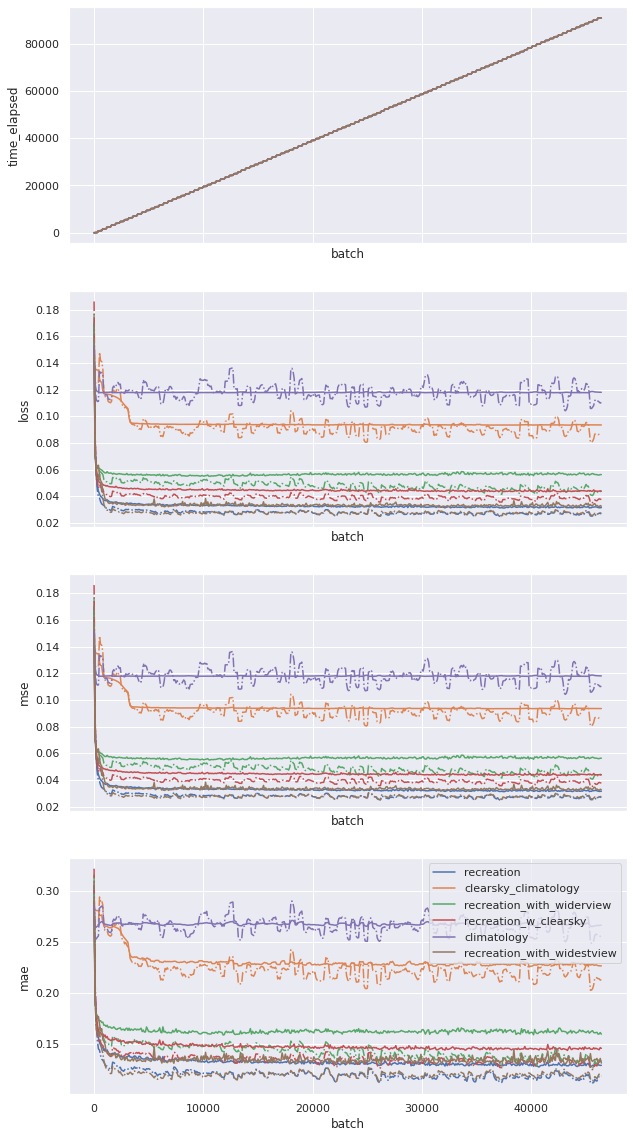

In [199]:
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
sns.set()


fig, axes = plt.subplots(4,1, sharex=True, figsize=(10,20))
axes = axes.flatten()
plot_metrics = ['time_elapsed', 'loss', 'mse', 'mae']

for ax, metric in zip(axes, plot_metrics):
    colors = cycle(prop_cycle.by_key()['color'])
    
    for i in range(len(model_dumps)):
        c = next(colors)
        df_ = dfs[i].rolling(1).mean()#.loc[2:]
        if metric=='time_elapsed':
            ax.plot(df_.index, df_[metric], label=model_dumps[i], color=c)
        else:
            ax.plot(df_.index, df_['train_'+metric], linestyle='-.', color=c)
            ax.plot(df_.index, df_['test_'+metric], linestyle='-', label=model_dumps[i], color=c)
    ax.set_xlabel('batch')
    ax.set_ylabel(metric)
ax.legend()
plt.show()

In [200]:
final_results_df = {}
for i,model in enumerate(model_dumps):
    df = dfs[i].iloc[-1:].mean()
    for ind in df.index:
        if ind in final_results_df.keys():
            final_results_df[ind].append(df[ind])
        else:
            final_results_df[ind] = [df[ind]]
pd.DataFrame(final_results_df, index=model_dumps).sort_values('test_loss').drop(['Unnamed: 0','train_loss','test_loss' ], axis=1)

,time_elapsed,train_mse,train_mae,test_mse,test_mae
recreation,90863.243843,0.026922,0.117540,0.031525,0.129395
recreation_with_widestview,90863.365863,0.027239,0.118724,0.032593,0.131592
recreation_w_clearsky,90863.183671,0.037665,0.131675,0.043945,0.145996
recreation_with_widerview,90863.133539,0.043390,0.132836,0.056274,0.159912
clearsky_climatology,90862.834071,0.085680,0.213368,0.093506,0.226929
climatology,90862.880215,0.110416,0.256564,0.117981,0.266846


Been having some cuda memory errors so move nets to cpu for simplicity

In [204]:
def slice_test_batch(sl):
    return {k:v[sl] for k, v in test_batch.items()}

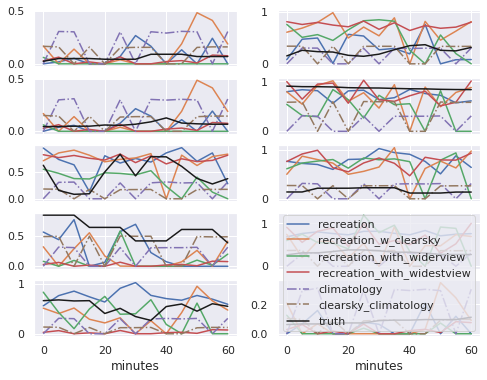

In [215]:
n = 10
np.random.seed(619)
cs = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

inds = np.random.randint(0, len(test_batch['y']), n)

fig, axes = plt.subplots(5,2, figsize=(8,6), sharex=True)
axes[4,0].set_xlabel('minutes')
axes[4,1].set_xlabel('minutes')

axes = axes.flatten()

x = np.arange(0, 65, 5)

for i, ind in enumerate(inds):
    batch = slice_test_batch(slice(ind, ind+2))
    for ci, container in enumerate(containers):
        linestyle = '-.' if 'climatology' in container.run_name else '-'
            
        axes[i].plot(x, container.net(batch).cpu().detach().numpy()[0], color=cs[ci],  
                     label=container.run_name, linestyle=linestyle)
    axes[i].plot(x, batch['y'][0].cpu().detach().numpy(), color='k', label='truth')

axes[i].legend()
#plt.tight_layout()
#plt.savefig("sequence_predictions.png")
plt.show()

In [222]:
def torch_nan_mse_axis(ypred, y):
    mask = (~torch.isnan(y)).type(torch.float16)
    dy2 = ((y-ypred)*mask)**2
    return (dy2/mask.sum(axis=0)).sum(axis=0)

def torch_nan_mae_axis(ypred, y):
    mask = (~torch.isnan(y)).type(torch.float16)
    dy2 = torch.abs((y-ypred)*mask)
    return (dy2/mask.sum(axis=0)).sum(axis=0)

In [224]:
mae_list = []
mse_list = []

for container in containers:
    mae_list.append(
        torch_nan_mae_axis(
            container.net(test_batch), 
            test_batch['y']
        ).cpu().detach().numpy())
    
    mse_list.append(
        torch_nan_mse_axis(
            container.net(test_batch), 
            test_batch['y']
        ).cpu().detach().numpy())

In [231]:
mae_with_time = pd.DataFrame(mae_list, index=[c.run_name for c in containers], columns=np.arange(0,65,5)).T
mse_with_time = pd.DataFrame(mse_list, index=[c.run_name for c in containers], columns=np.arange(0,65,5)).T

In [234]:
mae_with_time

,recreation,recreation_w_clearsky,recreation_with_widerview,recreation_with_widestview,climatology,clearsky_climatology
0,0.118652,0.119812,0.122192,0.122253,0.320801,0.187012
5,0.122437,0.125122,0.128052,0.125732,0.232666,0.187622
10,0.124084,0.124695,0.129883,0.128906,0.228027,0.320312
15,0.129150,0.125244,0.128296,0.127563,0.322754,0.183960
20,0.125854,0.129272,0.129272,0.133545,0.325195,0.325195
25,0.129883,0.132812,0.132935,0.133179,0.229370,0.182373
30,0.131958,0.136230,0.136719,0.137207,0.330566,0.181763
35,0.128662,0.130615,0.136963,0.139893,0.230957,0.180176
40,0.131958,0.330811,0.138916,0.135864,0.232910,0.330811
45,0.129395,0.130493,0.327881,0.136353,0.226440,0.327881


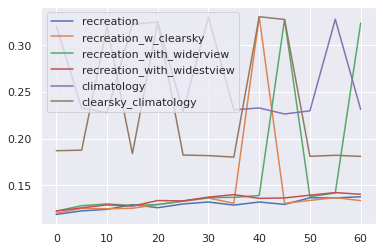

In [233]:
mae_with_time.plot()

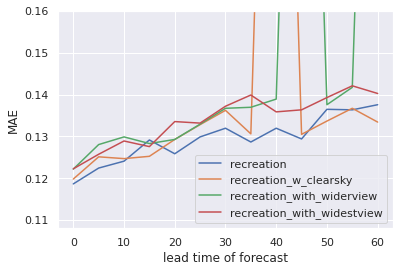

In [246]:
mae_with_time.loc[:,:'recreation_with_widestview'].plot()
plt.ylim(None, 0.16)
plt.xlabel('lead time of forecast')
plt.ylabel('MAE')
plt.show()

In [235]:
mse_with_time

,recreation,recreation_w_clearsky,recreation_with_widerview,recreation_with_widestview,climatology,clearsky_climatology
0,0.027557,0.028107,0.029297,0.029007,0.177979,0.053345
5,0.029343,0.030136,0.032562,0.031342,0.078003,0.054749
10,0.029312,0.030060,0.032471,0.031525,0.075500,0.177612
15,0.031006,0.030807,0.032806,0.031403,0.180664,0.053772
20,0.030701,0.031738,0.032745,0.033173,0.182251,0.182251
25,0.032440,0.033478,0.034637,0.033356,0.076721,0.054199
30,0.033020,0.034851,0.036530,0.035461,0.186279,0.054291
35,0.032043,0.033142,0.036194,0.036346,0.078064,0.053162
40,0.033630,0.187744,0.037476,0.035034,0.079651,0.187744
45,0.031555,0.032715,0.184204,0.033966,0.077087,0.184204


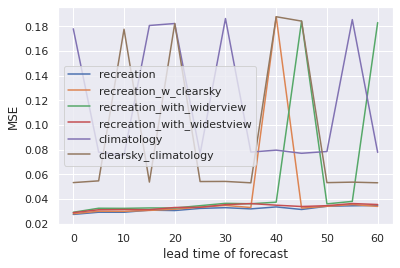

In [247]:
mse_with_time.plot()
plt.xlabel('lead time of forecast')
plt.ylabel('MSE')
plt.show()

In [249]:
y_df = pd.DataFrame(test_batch['y'].cpu().detach().numpy(), columns=np.arange(0,65, 5))

In [268]:
container = [c for c in containers if c.run_name=='recreation'][0]
ypref_df = pd.DataFrame(container.net(test_batch).cpu().detach().numpy(), columns=np.arange(0,65, 5))

In [286]:
ycomp_df = pd.melt(y_df, var_name='lead_time', value_name='y').join(pd.melt(ypref_df, var_name='lead_time', value_name='ypred').drop('lead_time', axis=1))

In [292]:
ycomp_df

,lead_time,y,ypred
0,0,0.082825,0.132324
1,0,0.094971,0.112671
2,0,0.621582,0.241577
3,0,0.030579,0.115784
4,0,0.892090,0.485596
...,...,...,...
12995,60,0.122070,0.374756
12996,60,0.281250,0.579102
12997,60,0.418701,0.391113
12998,60,0.053955,0.126587


In [305]:
ycomp_df.lead_time= pd.Categorical(ycomp_df.lead_time)

In [358]:
lead_time_unique = np.unique(ycomp_df.lead_time)
palette = sns.color_palette('plasma', n_colors=len(lead_time_unique))
colordict={k:colour for k, colour in zip(lead_time_unique,palette)}

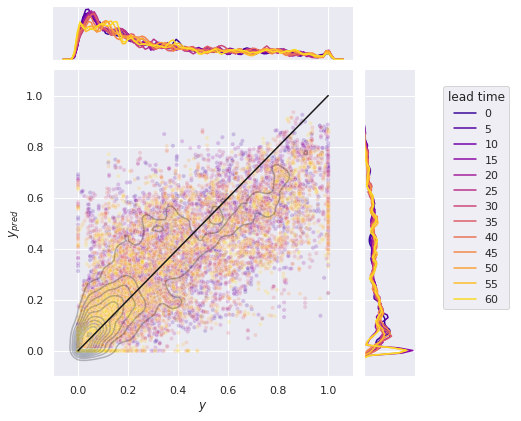

In [409]:
#ycomp_df.plot.scatter(x='y', y='ypred')

import seaborn as sns
import matplotlib as mpl

# set up plot grid structure
grid = sns.JointGrid(x='y', y='ypred', data=ycomp_df)

bw=0.02
kernel='epa'

# add central scatter and contour plots
g = grid.plot_joint(sns.scatterplot, hue='lead_time', data=ycomp_df, palette=colordict, size=1, alpha=0.2, legend=False)
grid.plot_joint(sns.kdeplot, alpha=0.3, bw=bw, kernel=kernel)

# add density plots on margins
for lt in lead_time_unique:
    sns.kdeplot(ycomp_df.query("lead_time==@lt").loc[:, 'y'], ax=g.ax_marg_x, legend=False, color=colordict[lt], bw=bw, kernel=kernel)
    sns.kdeplot(ycomp_df.query("lead_time==@lt").loc[:, 'ypred'], ax=g.ax_marg_y, vertical=True, legend=False, color=colordict[lt], bw=bw, kernel=kernel)

# formating
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel('$y$')
plt.ylabel('$y_{pred}$')

# add guidline
plt.plot([0,1], [0,1], color='k')

# add legend on new axis
cbar_ax = g.fig.add_axes([1, 0.1, .2, .7])
cbar_ax.legend(g.ax_marg_x.get_lines(), lead_time_unique, title='lead time')
cbar_ax.set_axis_off()


One thing to note here is that the target data itself is really skewed. I'm wondering if some transform of this data might make it easier to learn.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a45835090>,
      dtype=object)

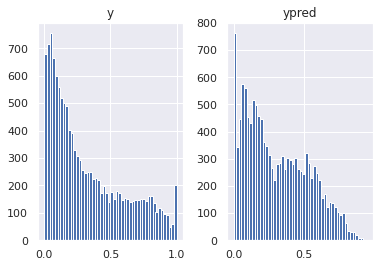

In [419]:
(ycomp_df.iloc[:, 1:]).hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a09d02250>,
      dtype=object)

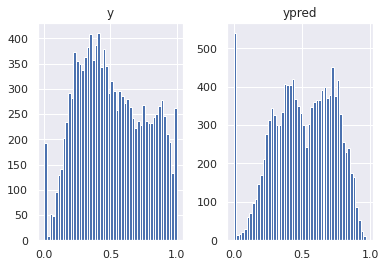

In [420]:
(ycomp_df.iloc[:, 1:]**0.5).hist(bins=50)

Another interesting point is the above distribution. Our predictions are much more central and have a smaller spread than the target. I think this is to be expected given that we are using MSE.